In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import sys
sys.path.append("../src/")

import read_files
import utils
import spectral_density
import absorption
import tqdm

In [2]:
LHII = read_files.all_LHII_data("300ps_2fs", 3000, True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.05it/s]
150000it [00:36, 4118.87it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 78.91it/s]


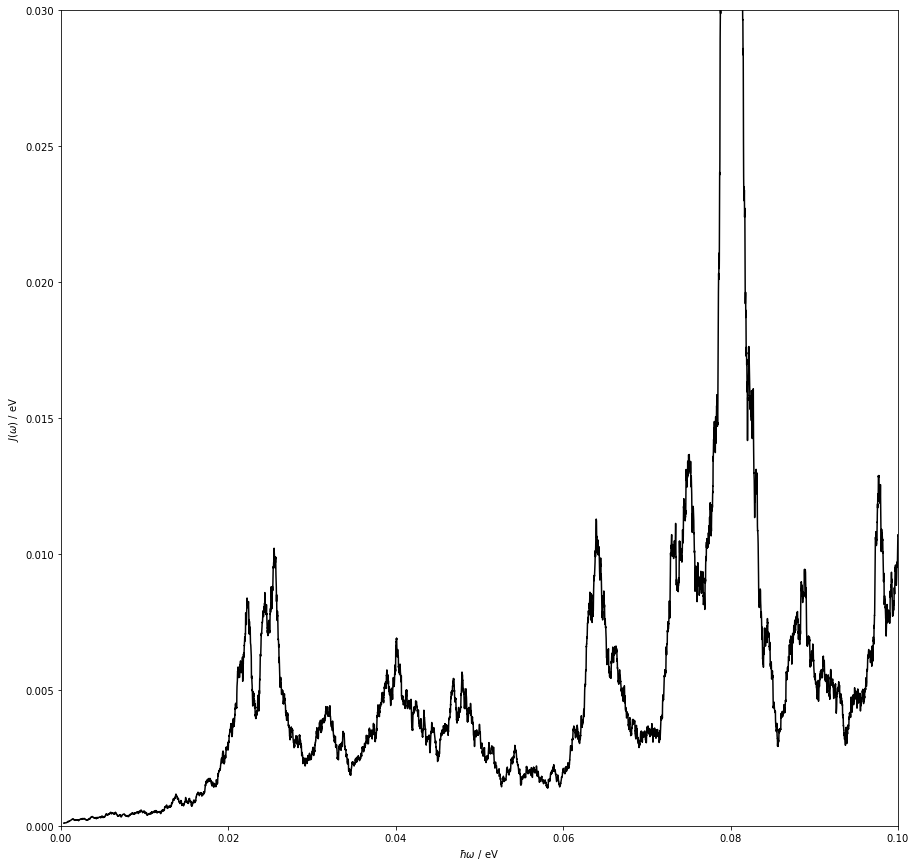

In [3]:
fig, ax = plt.subplots()


length = 150000 # * 2fs 
framerate = 1 # * 2fs 

dt = 2 * framerate
i = 0


#base
autocorr_LHII, spectrum_LHII, domain_LHII = spectral_density.spectrum_and_domain((LHII["site_e"][:, i][:length:framerate] - np.mean(LHII["site_e"][:, i][:length:framerate]))/utils.Eh_to_eV, dt)

N = 500

domain = utils.moving_average(utils.first_half(domain_LHII), N)
domain_eV = domain * utils.per_fs_to_eV
spectrum_eV = dt**2 * utils.moving_average(utils.first_half(np.abs(spectrum_LHII)), N) * spectral_density.thermal_correction(domain)

ax.plot(domain_eV, spectrum_eV, color='black')


length = 150000 # * 2fs 
framerate = 3 # * 2fs 

dt = 2 * framerate
i = 0


#Editing
#autocorr_LHII, spectrum_LHII, domain_LHII = spectral_density.spectrum_and_domain((LHII["site_e"][:, i][:length:framerate] - np.mean(LHII["site_e"][:, i][:length:framerate]))/utils.Eh_to_eV, dt)

#N = 500

#domain = utils.moving_average(utils.first_half(domain_LHII), N)
#domain_eV = domain * utils.per_fs_to_eV
#spectrum_eV = dt**2 * utils.moving_average(utils.first_half(np.abs(spectrum_LHII)), N) * spectral_density.thermal_correction(domain)

#ax.plot(domain_eV, spectrum_eV, color='red', linestyle='dashed')



ax.set_xlim(0, 0.1)
ax.set_ylim(0, 0.03)

ax.set_ylabel("$J(\omega)$ / eV")
ax.set_xlabel("$\hbar \omega$ / eV")

fig.set_size_inches(15, 15)

#plt.savefig("../images/specdens_literature_comparison.png")

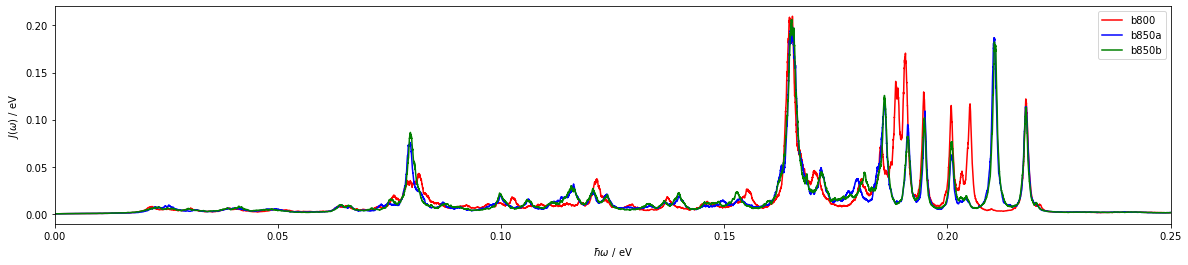

In [52]:
#Base

fig, ax = plt.subplots()

def thermal_corrected_specdens(series, dt=2, N=300):
    """
    calculates the spectral density, in units of eV, with the thermal correction factor.
    
    Does take responsibility of calculating deviation to mean
    """
    
    autocorr, spectrum, domain = spectral_density.spectrum_and_domain((series - np.mean(series))/utils.Eh_to_eV, dt)

    avd_domain = utils.moving_average(utils.first_half(domain), N)
    domain_eV   = avd_domain * utils.per_fs_to_eV
    spectrum_eV = dt**2 * utils.moving_average(utils.first_half(np.abs(spectrum)), N) * spectral_density.thermal_correction(avd_domain) # dt^2 factor due to discrete fourier transform

    return domain_eV, spectrum_eV
    
    
def ring_average(ring):
    ring_domain = None
    ring_spectra = None

    for i in ring:
        domain_eV, spectrum_eV = thermal_corrected_specdens(LHII["site_e"][:, i])

        if ring_domain is None and ring_spectra is None:
            ring_domain = domain_eV
            ring_spectra = spectrum_eV
        else:
            ring_domain += domain_eV
            ring_spectra += spectrum_eV

    ring_domain /= 9
    ring_spectra /= 9
    
    return ring_domain, ring_spectra

b800_domain, b800_spectra = ring_average(utils.b800)
ax.plot(b800_domain, b800_spectra, color='red', label='b800')

b850a_domain, b850a_spectra = ring_average(utils.b850a)
ax.plot(b850a_domain, b850a_spectra, color='blue', label='b850a')

b850b_domain, b850b_spectra = ring_average(utils.b850b)
ax.plot(b850b_domain, b850b_spectra, color='green', label='b850b')


ax.set_xlim(0, 0.25)
#ax.set_ylim(0, 0.03)
ax.legend()

ax.set_ylabel("$J(\omega)$ / eV")
ax.set_xlabel("$\hbar \omega$ / eV")

fig.set_size_inches(20, 4)

#plt.savefig("../images/specdens_ring_average.png") 

# All data

In [6]:
lights, spheres = absorption.probabilities(LHII["eigvec"], LHII["dipoles"])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150000/150000 [19:29<00:00, 128.27it/s]


In [46]:
average_sphere = np.array([np.mean(spheres[:, i]) for i in range(27)])
weight = [x/np.max(average_sphere) for x in average_sphere]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:12<00:00,  2.06it/s]


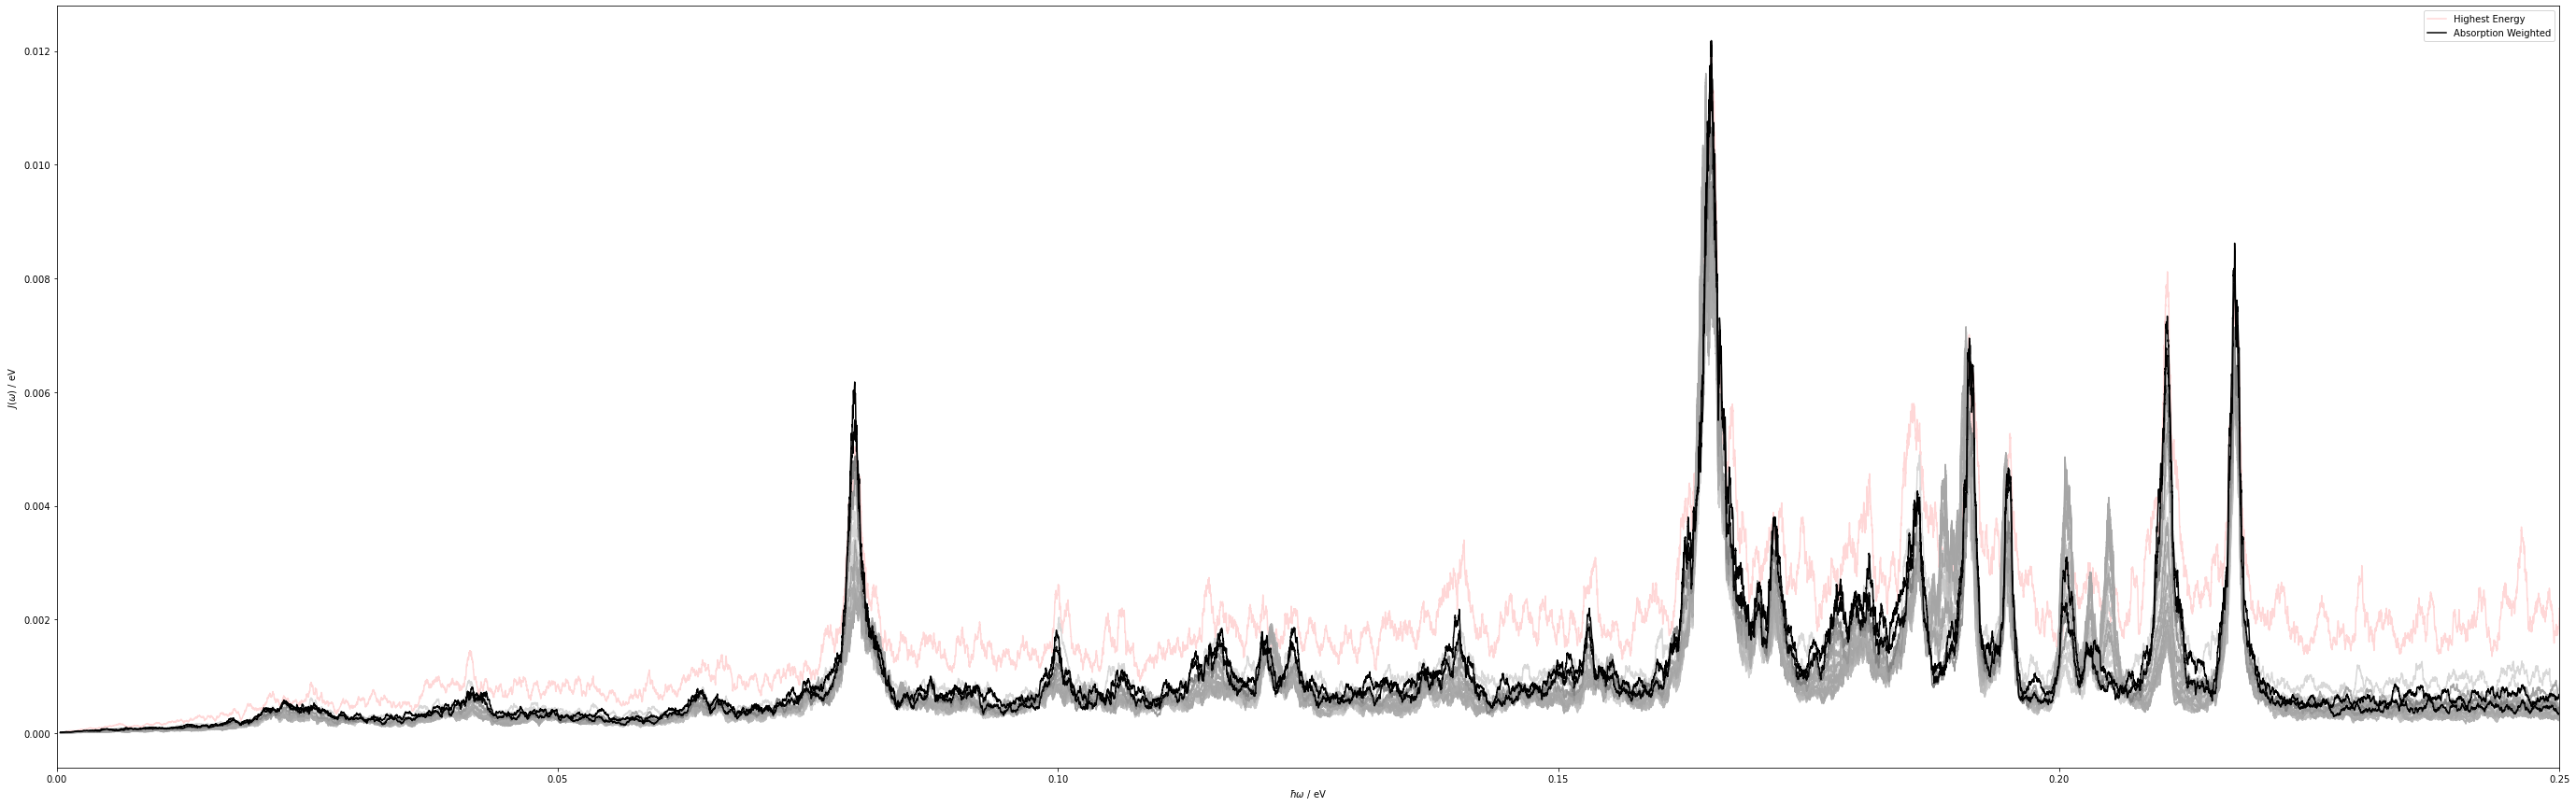

In [8]:
fig = plt.figure()

ax = fig.add_subplot(111)

eigval_domain, eigval_spectrum = thermal_corrected_specdens(LHII["eigval"][:, 26+1]-LHII["eigval"][:, 0], N=500)
ax.plot(eigval_domain, eigval_spectrum, color='red', alpha=weight[-1], label='Highest Energy')

for i in tqdm.tqdm(range(25, 0, -1)):
    eigval_domain, eigval_spectrum = thermal_corrected_specdens(LHII["eigval"][:, i+1]-LHII["eigval"][:, 0], N=500)
    
    if weight[i] == 1:
        ax.plot(eigval_domain, eigval_spectrum, color=f"{1-weight[i]}", label='Absorption Weighted')
    else:
        ax.plot(eigval_domain, eigval_spectrum, color=f"{1-weight[i]}")

ax.set_xlim(0, 0.25)

ax.set_ylabel("$J(\omega)$ / eV")
ax.set_xlabel("$\hbar \omega$ / eV")
ax.legend()

fig.set_size_inches(48, 15)

plt.savefig("../images/state_spectra.png")

Text(0.5, 0, '$\\Delta E_{exciton}$ / eV')

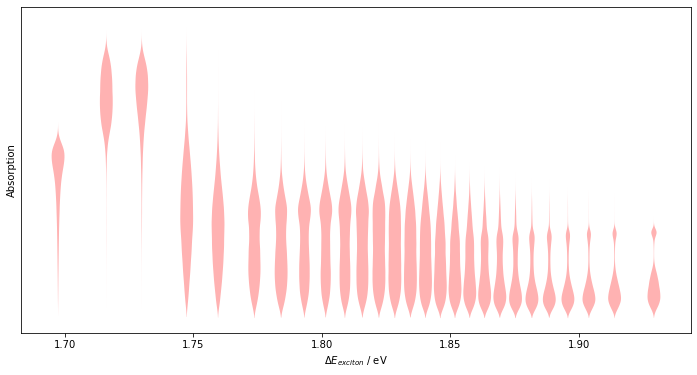

In [50]:
fig, ax = plt.subplots()

dE = np.array([LHII["eigval"][:, i] - LHII["eigval"][:, 0] for i in range(1, 28)])

means = np.mean(dE, axis=1)

parts = ax.violinplot(lights, positions=means*27.2114, showextrema=False, widths=0.005)

for pc in parts["bodies"]:
    pc.set_facecolor('red')

fig.set_size_inches(12, 6)

ax.set_yticks([])
ax.set_ylabel("Absorption")
ax.set_xlabel("$\Delta E_{exciton}$ / eV")

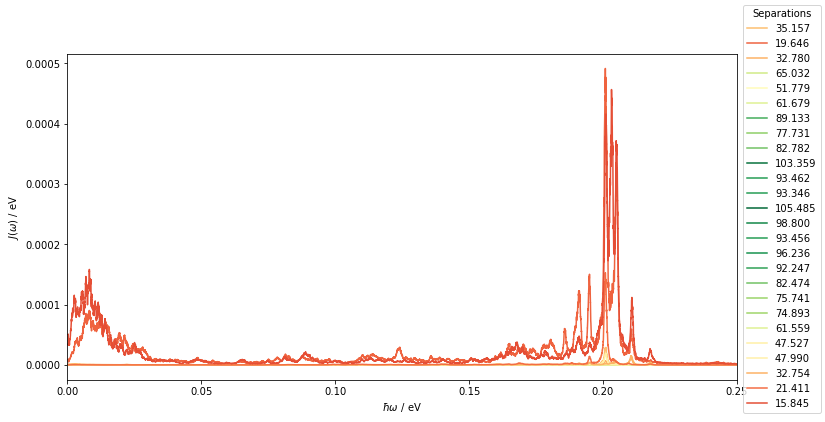

In [44]:
fig, ax = plt.subplots()

ax.set_xlim(0, 0.25)

distances = np.mean(LHII["distances"][:, 0, :], axis=0)

colors = plt.cm.RdYlGn(distances/np.max(distances))

for i in range(1,2):
    for j in range(i+1, 28):
        couple_domain, couple_spectrum = thermal_corrected_specdens(np.abs(LHII["hamils"][:, i, j]), N=500)
        
        ax.plot(couple_domain, couple_spectrum, color=colors[j-1], label=f"{distances[j-1]:3.3f}")
        
ax.set_ylabel("$J(\omega)$ / eV")
ax.set_xlabel("$\hbar \omega$ / eV")

fig.legend(title='Separations')

fig.set_size_inches(12, 6)

19.645769420064575
15.844678319896879


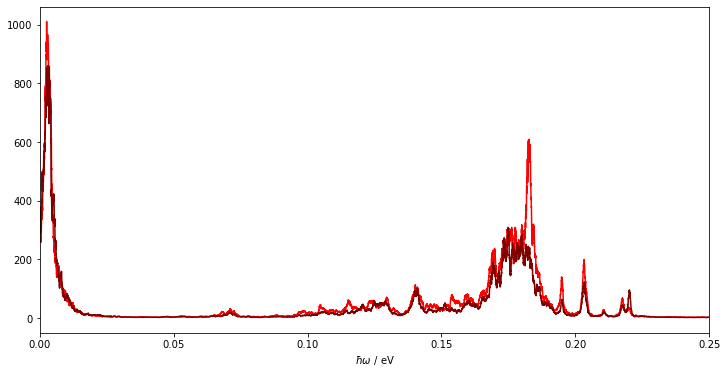

In [70]:
fig, ax = plt.subplots()

print(np.mean(LHII["distances"][:, 0, 2]))
print(np.mean(LHII["distances"][:, 0, 26]))

distance_domain, distance_spectrum = thermal_corrected_specdens(LHII["distances"][:, 0, 2], N=500)
ax.plot(distance_domain, distance_spectrum, color='red')

distance_domain, distance_spectrum = thermal_corrected_specdens(LHII["distances"][:, 0, 26], N=500)
ax.plot(distance_domain, distance_spectrum, color='maroon')

ax.set_xlim(0, 0.25)

ax.set_xlabel("$\hbar \omega$ / eV")

fig.set_size_inches(12, 6)

670.674752
727.409421
1166.792831
1185.698076
1220.518895
1323.725675
1538.307155


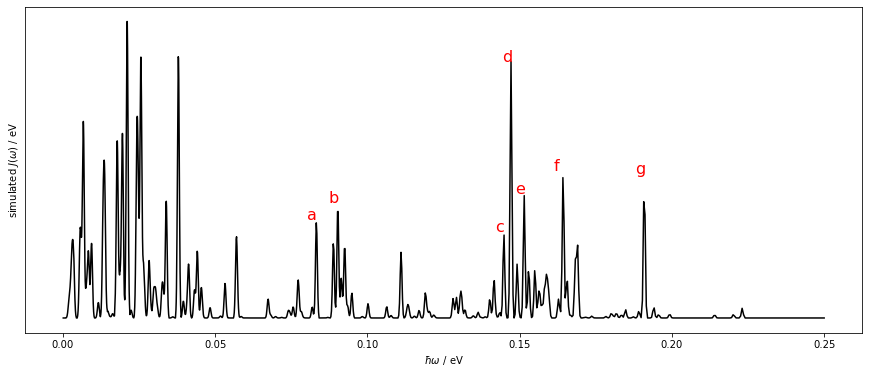

In [71]:
fig, ax = plt.subplots(figsize=(15, 6))

#ax.set_xlim(0, 0.25)

start, end = 1e-4, 0.25
num = 3500

p_range = (start, end, num)

#i=1
#eigval_domain, eigval_spectrum = thermal_corrected_specdens(LHII["eigval"][:, i+1]-LHII["eigval"][:, 0], N=500)
#ax2.plot(eigval_domain, eigval_spectrum, color=f"{1-weight[i]}")

#Huang-Rhys factors
import json
with open("../data/hessians/huang_rhys.json") as hr_json:
    res = json.load(hr_json)
    
hrfs = np.array([res[x]["hrf"] for x in res.keys()])
wavenumbers = np.array([res[x]["wavenumber"] for x in res.keys()])
freqs = np.array([res[x]["frequency"] * utils.per_fs_to_eV for x in res.keys()])

import string

l=0
for enum, (hrf, freq) in enumerate(zip(hrfs, freqs)):
    if hrf > 0.16 and freq > 0.07:
        ax.annotate(string.ascii_lowercase[l], (freq-0.003, hrf+0.005), color='red', size=16)
        l +=1 
        
        print(wavenumbers[enum])

hrf_broadening = spectral_density.gaussians_static_broadening(hrfs, freqs, 0.0003, 0)
spectral_density.plot_gaussians(hrf_broadening, 0.6, ax, p_range=p_range);

ax.set_ylabel("simulated $ J ( \omega ) $ / eV")
ax.set_yticks([])
ax.set_xlabel("$\hbar \omega$ / eV");

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:13<00:00,  1.98it/s]


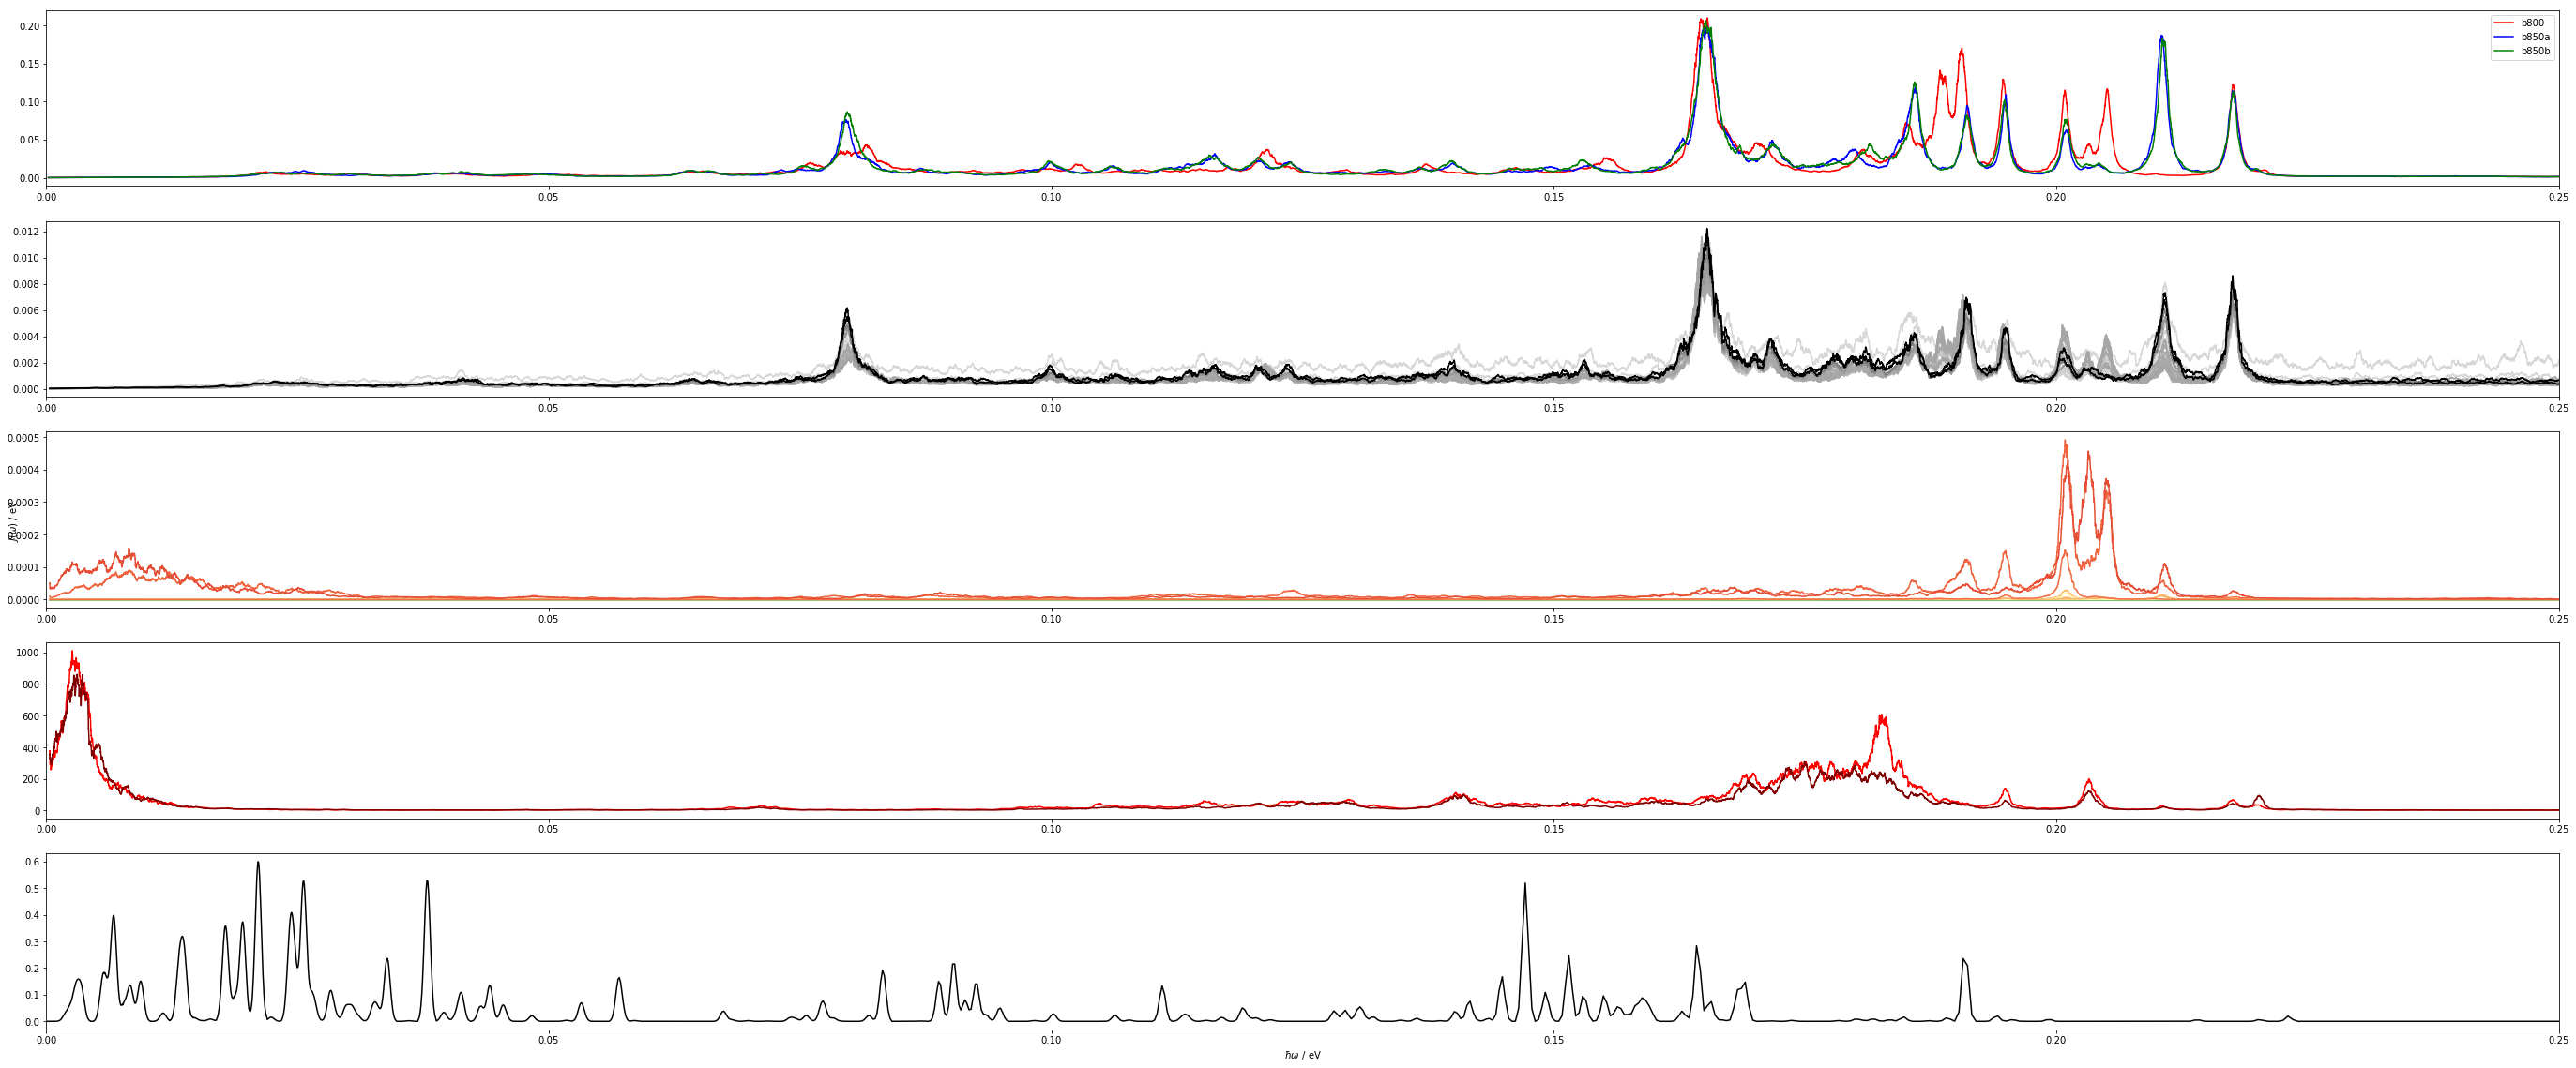

In [76]:
fig = plt.figure()

ax_main = fig.add_subplot(111)

# Turn off axis lines and ticks of the big subplot
ax_main.spines['top'].set_color('none')
ax_main.spines['bottom'].set_color('none')
ax_main.spines['left'].set_color('none')
ax_main.spines['right'].set_color('none')
ax_main.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax_sites = fig.add_subplot(511)
ax_eigval = fig.add_subplot(512)
ax_couple = fig.add_subplot(513)
ax_distance = fig.add_subplot(514)
ax_hrf = fig.add_subplot(515)
#ax_ether = fig.add_subplot(516)


b800_domain, b800_spectra = ring_average(utils.b800)
ax_sites.plot(b800_domain, b800_spectra, color='red', label='b800')

b850a_domain, b850a_spectra = ring_average(utils.b850a)
ax_sites.plot(b850a_domain, b850a_spectra, color='blue', label='b850a')

b850b_domain, b850b_spectra = ring_average(utils.b850b)
ax_sites.plot(b850b_domain, b850b_spectra, color='green', label='b850b')

for i in tqdm.tqdm(range(26, 0, -1)):
    eigval_domain, eigval_spectrum = thermal_corrected_specdens(LHII["eigval"][:, i+1]-LHII["eigval"][:, 0], N=500)
    ax_eigval.plot(eigval_domain, eigval_spectrum, color=f"{1-weight[i]}")
    

distance_domain, distance_spectrum = thermal_corrected_specdens(LHII["distances"][:, 0, 2], N=500)
ax_distance.plot(distance_domain, distance_spectrum, color='red')

distance_domain, distance_spectrum = thermal_corrected_specdens(LHII["distances"][:, 0, 26], N=500)
ax_distance.plot(distance_domain, distance_spectrum, color='maroon')
    
    
distances = np.mean(LHII["distances"][:, 0, :], axis=0)

colors = plt.cm.RdYlGn(distances/np.max(distances))

for i in range(1,2):
    for j in range(i+1, 28):
        couple_domain, couple_spectrum = thermal_corrected_specdens(np.abs(LHII["hamils"][:, i, j]), N=500)
        
        ax_couple.plot(couple_domain, couple_spectrum, color=colors[j-1])

hrf_broadening = spectral_density.gaussians_static_broadening(hrfs, freqs, 0.0003, 0)
spectral_density.plot_gaussians(hrf_broadening, 0.6, ax_hrf, p_range=p_range);

ax_sites.set_xlim(0, 0.25)
ax_eigval.set_xlim(0, 0.25)
ax_couple.set_xlim(0, 0.25)
ax_distance.set_xlim(0, 0.25)
ax_hrf.set_xlim(0, 0.25)
ax_sites.legend()

ax_main.set_ylabel("$J(\omega)$ / eV")
ax_main.set_xlabel("$\hbar \omega$ / eV")

fig.set_size_inches(48, 20)

plt.savefig("../images/sites_states_coupling.png")
